In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ECG_function import *
%matplotlib inline

# "Naive" Fourier Transformation
## Data Importing

In [2]:
Xtrain,Ytrain,Xtest = DataImporting()
lable = Ytrain.TARGET.values

In [3]:
#test
DataSample(Xtrain,[1,2],1)

,ML1_0,ML1_1,ML1_2,ML1_3,ML1_4,ML1_5,ML1_6,ML1_7,ML1_8,ML1_9,...,ML1_740,ML1_741,ML1_742,ML1_743,ML1_744,ML1_745,ML1_746,ML1_747,ML1_748,ML1_749
1,0.018403,0.026159,0.009684,0.001014,-0.000866,0.002019,0.000617,-0.011167,-0.026314,-0.026881,...,-0.030683,-0.027179,-0.023822,-0.021767,-0.021504,-0.022533,-0.023832,-0.023974,-0.021915,-0.017584
2,-0.020974,-0.044294,-0.044097,-0.042136,-0.041125,-0.034392,-0.033026,-0.031817,-0.032347,-0.034317,...,0.013544,-0.013377,-0.038524,-0.038650,-0.039073,-0.051832,-0.069153,-0.081822,-0.086272,-0.088153


## Feature Collection
We consider a fft transformation for all the 12 channels's signals.

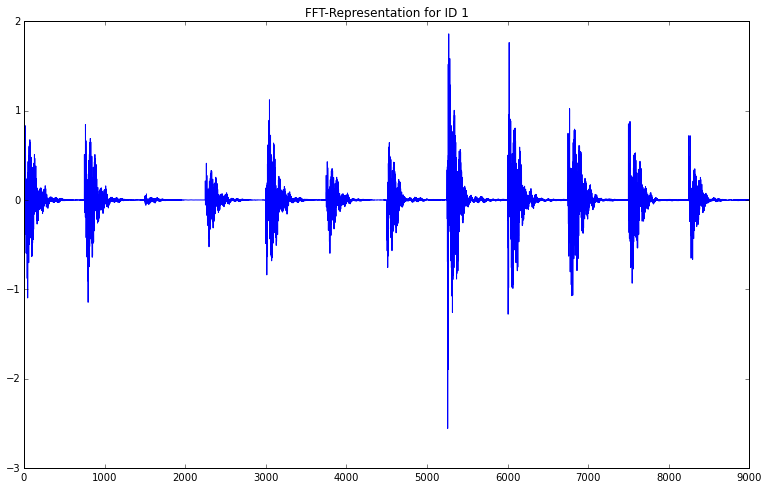

In [4]:
from scipy.fftpack import dct, idct
#a = list(dct(DataSample(Xtrain,1,12).values, norm='ortho'))+list(dct(DataSample(Xtrain,1,11).values, norm='ortho'))
AllFeatures_fft =[[] for i in range(1000)]
for id in range(1000):
    for k in range(1,13):
        AllFeatures_fft[id] += list(dct(DataSample(Xtrain,id,k).values, norm='ortho'))
#test for id 1
plt.figure(figsize=(13,8))
plt.plot(AllFeatures_fft[1])
plt.title("FFT-Representation for ID 1")


## Feature Selction
We will use a classic F-test method.

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif

Select = SelectKBest(f_classif, k=110)
SelectedFeatures = Select.fit_transform(AllFeatures_fft, lable)
np.shape(AllFeatures_fft)

(1000, 9000)

# Classification
## Gaussian NB

In [28]:
from sklearn.naive_bayes import GaussianNB 

N_sep = len(lable)*2/3

gnb = GaussianNB()
gnb.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print gnb.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_gnb = gnb.predict(SelectedFeatures[N_sep:])

0.751497005988


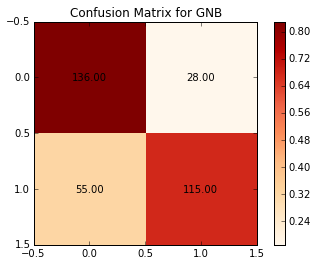

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(lable[N_sep:],feat_pred_gnb)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'OrRd')
plt.colorbar()
plt.title('Confusion Matrix for GNB')
for y in range(2):
    for x in range(2):
        plt.text(x, y , '%.2f' % cm[y,x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

## SVM
We select the kernel linear.

In [30]:
from sklearn import svm
svm = svm.SVC(kernel='linear')#‘linear!!!’ or 'poly'
svm.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print svm.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_svm = svm.predict(SelectedFeatures[N_sep:])

0.682634730539


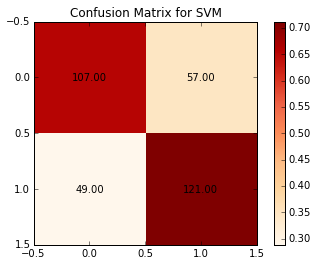

In [31]:
cm = confusion_matrix(lable[N_sep:],feat_pred_svm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'OrRd')
plt.title('Confusion Matrix for SVM')
plt.colorbar()
for y in range(2):
    for x in range(2):
        plt.text(x, y , '%.2f' % cm[y,x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

## Random Forest
We set the n_estimetors = 50.

In [34]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100)
RF.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print RF.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_RF = RF.predict(SelectedFeatures[N_sep:])

0.778443113772


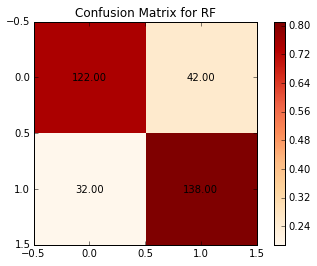

In [35]:
cm = confusion_matrix(lable[N_sep:],feat_pred_RF)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'OrRd')
plt.title('Confusion Matrix for RF')
plt.colorbar()
for y in range(2):
    for x in range(2):
        plt.text(x, y , '%.2f' % cm[y,x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

## BenchMark for Different Number of Features

In [15]:
k_gnb = []
k_svm = []
k_rf = []

for num_feature in range(100,2000,100):
    Selec = SelectKBest(f_classif, k = num_feature )
    train_data_features = Selec.fit_transform(AllFeatures_fft, lable)
    
    #GNB
    gnb.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_gnb.append(gnb.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #SVM  
    svm.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_svm.append(svm.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #RF
    RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_rf.append(RF.score(train_data_features[N_sep:], lable[N_sep:]))
    


In [16]:
BenchMark = pd.DataFrame({"GNB":k_gnb,"SVM":k_svm,'RF':k_rf})
BenchMark.index = ["k = "+ str(i) for i in range(100,2000,100)]
BenchMark

,GNB,RF,SVM
k = 100,0.745509,0.775449,0.700599
k = 200,0.781437,0.736527,0.700599
k = 300,0.760479,0.736527,0.706587
k = 400,0.751497,0.790419,0.706587
k = 500,0.760479,0.766467,0.715569
k = 600,0.757485,0.748503,0.697605
k = 700,0.742515,0.763473,0.727545
k = 800,0.739521,0.808383,0.703593
k = 900,0.730539,0.754491,0.700599
k = 1000,0.727545,0.772455,0.694611


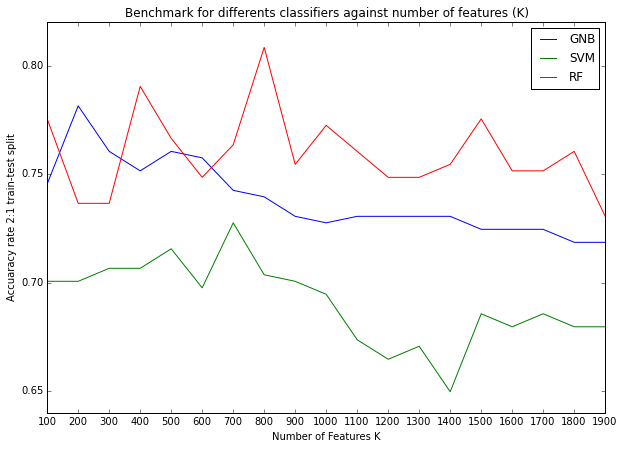

In [17]:
plt.figure(figsize = (10,7))
plt.plot(BenchMark["GNB"])
plt.plot(BenchMark["SVM"])
plt.plot(BenchMark["RF"])
plt.xticks(range(0,19),range(100,2000,100))
plt.legend(['GNB','SVM','RF'])
plt.xlabel("Number of Features K")
plt.ylabel("Accuaracy rate 2:1 train-test split")
plt.title("Benchmark for differents classifiers against number of features (K)")

In [23]:
k_gnb = []
k_svm = []
k_rf = []

for num_feature in range(10,200,10):
    Selec = SelectKBest(f_classif, k = num_feature )
    train_data_features = Selec.fit_transform(AllFeatures_fft, lable)
    
    #GNB
    gnb.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_gnb.append(gnb.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #SVM  
    svm.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_svm.append(svm.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #RF
    RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_rf.append(RF.score(train_data_features[N_sep:], lable[N_sep:]))
    

In [24]:
BenchMark2 = pd.DataFrame({"GNB":k_gnb,"SVM":k_svm,'RF':k_rf})
BenchMark2.index = ["k = "+ str(i) for i in range(10,200,10)]
BenchMark2

,GNB,RF,SVM
k = 10,0.700599,0.691617,0.691617
k = 20,0.721557,0.733533,0.700599
k = 30,0.745509,0.757485,0.700599
k = 40,0.760479,0.736527,0.709581
k = 50,0.769461,0.757485,0.706587
k = 60,0.769461,0.772455,0.718563
k = 70,0.769461,0.751497,0.694611
k = 80,0.739521,0.760479,0.700599
k = 90,0.745509,0.766467,0.691617
k = 100,0.745509,0.775449,0.700599


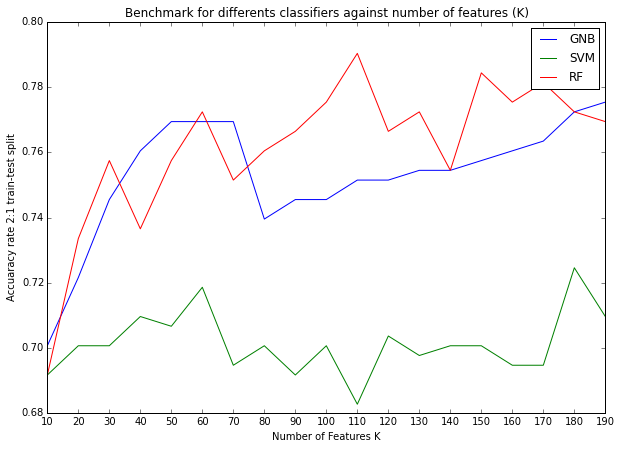

In [26]:
plt.figure(figsize = (10,7))
plt.plot(BenchMark2["GNB"])
plt.plot(BenchMark2["SVM"])
plt.plot(BenchMark2["RF"])
plt.xticks(range(0,19),range(10,200,10))
plt.legend(['GNB','SVM','RF'])
plt.xlabel("Number of Features K")
plt.ylabel("Accuaracy rate 2:1 train-test split")
plt.title("Benchmark for differents classifiers against number of features (K)")

### With these plots, we consider of using the algorithm RF with K = 110.

## Cross-Validation

In [37]:
from sklearn import cross_validation
scores  = cross_validation.cross_val_score(RF, SelectedFeatures, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.88118812  0.84158416  0.76        0.8         0.9         0.83        0.83
  0.84        0.72727273  0.75757576]
0.816762076208
